In [1]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from models import Models
from morph import Morph
from sklearn.preprocessing import LabelEncoder

In [3]:
ECG_datasets = ['AtrialFibrillation', 'CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays', 'NonInvasiveFetalECGThorax1',
                'NonInvasiveFetalECGThorax2', 'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']


df_name = 'ECG200'
X, y = load_classification(df_name)
print("Shape of X = ", X.shape)

le = LabelEncoder()
y = le.fit_transform(y)
print(f'Classes: {np.unique(y)}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of X =  (200, 1, 96)
Classes: [0 1]


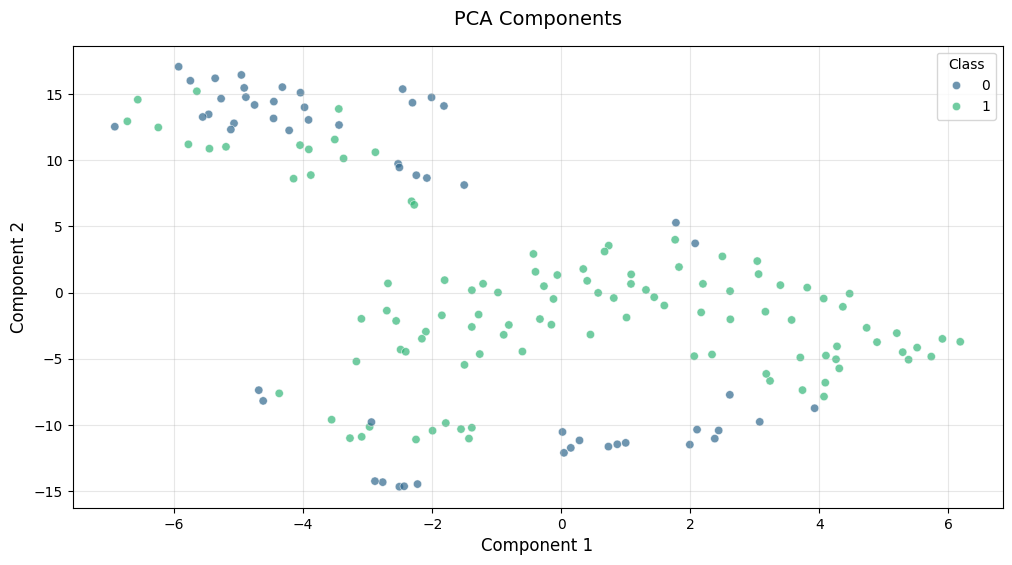

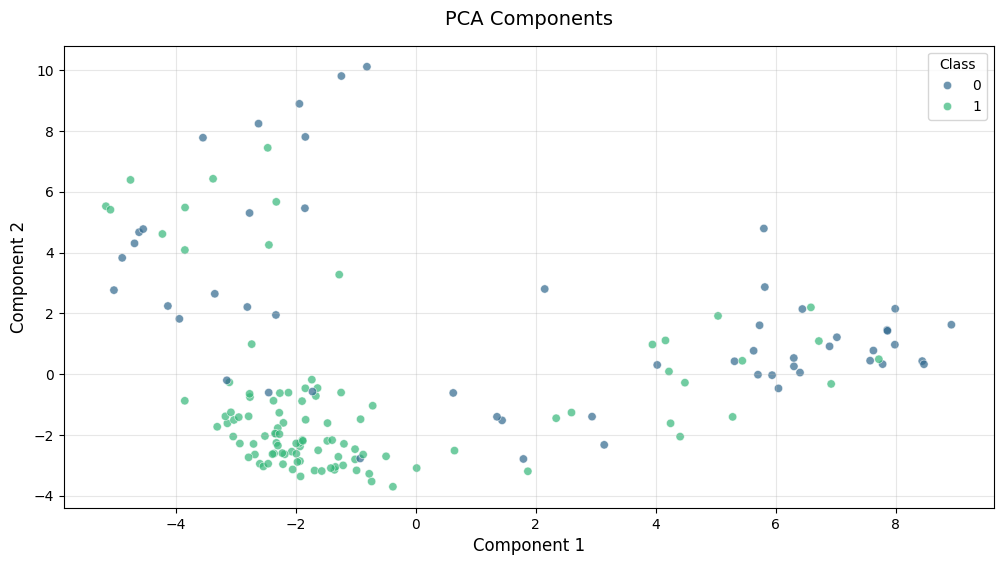

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne
    
def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def plot_components(X, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title('PCA Components', fontsize=14, pad=15)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Class')
    plt.show()

X_tsne = getTSNE(X_train.squeeze(axis=1), 2)
plot_components(X_tsne, y_train)

X_pca = getPCA(X_train.squeeze(axis=1), 2)
plot_components(X_pca, y_train)

In [ ]:
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder

ECG_datasets = ['AtrialFibrillation', 'CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays',
                'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']

# Use a dictionary instead of a list to track sizes
dataset_sizes = {}

for df_name in ECG_datasets:
    try:
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Store the dataset size in the dictionary
        dataset_sizes[df_name] = X.shape[0]
    except:
        print(f'{df_name} Dataset Not Available')
        continue

# Sort the dictionary by size (from smallest to largest)
sorted_datasets = dict(sorted(dataset_sizes.items(), key=lambda item: item[1]))

# Print the sorted datasets with their sizes
for dataset, size in sorted_datasets.items():
    print(f"{dataset}: {size} samples")

CardiacArrhythmia Dataset Not Available
StandWalkJump: 27 samples
AtrialFibrillation: 30 samples
ECG200: 200 samples
NerveDamage: 204 samples
ECGFiveDays: 884 samples
MedicalImages: 1141 samples
TwoLeadECG: 1162 samples
CinCECGTorso: 1420 samples
ECG5000: 5000 samples


In [2]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from collections import Counter

from source.models import Models
from source.morph import Morph

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

multivariate = ['AtrialFibrillation', 'EMOPain', 'Epilepsy', 
                'EyesOpenShut', 'HandMovementDirection', 'Heartbeat']

# Initialize variables to store results
all_results = {}
results_array = np.empty((0, 11))  # Initialize an empty NumPy array with 9 columns

# Loop through each dataset
for df_name in multivariate:
    results = {}

    try:
        # Load dataset
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
    except Exception as e:
        print(f'{df_name}: Dataset Not Available - {str(e)}')
        continue

    # # Skip multivariate time series
    # if X.shape[1] != 1:
    #     print(f'{df_name}: Multivariate Time Series - Skipping')
    #     continue

    print('-' * 60)
    print(f'Processing Dataset: {df_name}')

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculate dataset size and number of classes
    ts_length = X_train.shape[2]
    df_size = X_train.shape[0]
    n_classes = len(np.unique(y))  # Total number of classes
    variates = X_train.shape[1]  # Number of variates

    # Count the frequency of each class
    class_counts = Counter(y_train)
    num_classes = len(class_counts)

    # Train Models
    start = time.time()
    lstm = Models('lstm', X_train, y_train)
    lstm.train_lstm()
    catch = Models('catch22', X_train, y_train)
    catch.train_catch22()
    rocket = Models('rocket', X_train, y_train)
    rocket.train_rocket()

    training_time = time.time()
    print(f'Training time: {training_time - start}')

    # Evaluate models
    models = (lstm, catch, rocket)
    acc = {}
    for m in models:
        pred, _ = m.predict(X_test)
        acc[m.model_name] = accuracy_score(pred, y_test)

    # Loop through each class
    for c in np.unique(y):
        start_class = time.time()
        print(f'Processing Class: {c}')

        # Calculate class percentage
        class_perc = round(class_counts[c] / df_size, 3)

        # Perform morphing calculations
        mor = Morph(X_test, y_test, c)
        mor.get_DTWGlobalBorderline(perc_samples=0.1)
        res = mor.Binary_MorphingCalculater(models)

        end_class = time.time()
        print(f'Total Class {c} run time: {end_class - start_class}')

        # Store results for the class
        results[c] = res

        class_decoed = le.inverse_transform([c])[0]
        print(class_decoed)

        # Append results to NumPy array
        for model in res.keys():
            data = res[model]['metrics']
            line = np.array([[df_name, df_size, variates, ts_length, n_classes, class_decoed, class_perc, model, data['mean'], data['std'], acc[model]]])
            results_array = np.vstack((results_array, line))
        

    # Save results for the current dataset
    file_name = f'results/pickles/{df_name}.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(results, f)

    # Add results to all_results
    all_results[df_name] = results

    # Clean ups
    del models, lstm, catch, rocket, results

    # Convert NumPy array to Pandas DataFrame
    columns = ['dataset', 'df_size', 'n_variates','ts_length', 'n_classes', 'class', 'class_perc', 'model', 'mean', 'std', 'model_acc']
    dataframe = pd.DataFrame(results_array, columns=columns)
    # Save results to CSV
    dataframe.to_csv('results/multivar.csv', index=False)

    # Save all results to a single pickle file
    with open('results/pickles/multivar.pkl', 'wb') as f:
        pickle.dump(all_results, f)

print('All results saved successfully!')

------------------------------------------------------------
Processing Dataset: AtrialFibrillation
Training time: 8.238038301467896
Processing Class: 0


100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


Total Class 0 run time: 10.068702220916748
n
Processing Class: 1


100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


Total Class 1 run time: 10.079204797744751
s
Processing Class: 2


0it [00:00, ?it/s]


Total Class 2 run time: 0.01820516586303711
t
------------------------------------------------------------
Processing Dataset: EMOPain
Training time: 198.09628462791443
Processing Class: 0


 27%|██▋       | 331/1244 [1:18:21<3:36:09, 14.21s/it]


KeyboardInterrupt: 

In [2]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

from source.models import Models
from source.morph import Morph

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

ECG_datasets = ['CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays'
                'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']

new_df = ['AbnormalHeartbeat', 'BinaryHeartbeat',
          'Colposcopy', 'EOGHorizontalSignal', 'EOGVerticalSignal',
          'EyesOpenShut', 'Sleep', 'ToeSegmentation1']

multivariate = ['AtrialFibrillation', 'Heartbeat', 'EMOPain', 'Epilepsy', 
                'EyesOpenShut', 'HandMovementDirection']


for df_name in multivariate:
    results = {}
    
    try:
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
    except:
        print(df_name, 'Dataset Not Available')
        continue

    # if X.shape[1] != 1:
    #     print(df_name, 'Multivariate Time Series')
    #     multivariate.append(df_name)
    #     continue

    print('-'*60)
    print(df_name)
    print(X.shape)
    print(np.unique(y))

------------------------------------------------------------
AtrialFibrillation
(30, 2, 640)
[0 1 2]
------------------------------------------------------------
Heartbeat
(409, 61, 405)
[0 1]
------------------------------------------------------------
EMOPain
(1323, 30, 200)
[0 1 2]
------------------------------------------------------------
Epilepsy
(275, 3, 206)
[0 1 2 3]
------------------------------------------------------------
EyesOpenShut
(98, 14, 128)
[0 1]
------------------------------------------------------------
HandMovementDirection
(234, 10, 400)
[0 1 2 3]
